In [1]:
import numpy as np
import pandas as pd
from statistics import mean
from random import choice
%matplotlib inline
import matplotlib.pyplot as plt

from gendis.genetic import GeneticExtractor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tools.data_extraction import DataExtractor
from tools.trajectory_generator import TrajectoryGenerator
from tools.utils import standardize_data, print_genetic_param, print_settings, set_movements, angle_diff, get_distance
from tools.experiments import Experiments

np.random.seed(1337)  # Random seed for reproducibility

tr_gen_options = {"samples": 25,
                  "freq": 3,
                  "reset_data": True}
dt_gen_options = {"n_test": 150}

train_test_options = {"split": 25}

df_csv_options = {"ts_class": "Bearing"}

gen_options = {"population_size": 20,
               "iterations": 5,
               "verbose": True,
               "normed": True,
               "add_noise_prob": 0.0,
               "add_shapelet_prob": 0.3,
               "wait": 10,
               "plot": True,
               "remove_shapelet_prob": 0.3,
               "crossover_prob": 0.66,
               "n_jobs": 4}

settings = {"trajectory_generator_options": tr_gen_options,
            "data_generation_options": dt_gen_options,
            "train_test_options":train_test_options,
            "define_csvs_option": df_csv_options,
            "genetic_options": gen_options}

tr_gen_options = settings["trajectory_generator_options"]
dt_gen_options = settings["data_generation_options"]
df_csvs_options = settings["define_csvs_option"]
train_test_options = settings["train_test_options"]
genetic_options = settings["genetic_options"]

first_movement = ['creeping_line_left']
second_movement = ['random']
movements = {'first_movement': first_movement,'second_movement': second_movement}
set_movements(movements)


In [2]:
# Create files if not created
tr_gen = TrajectoryGenerator(**tr_gen_options)
tr_gen.data_generation(**dt_gen_options)
# Read in the datafiles
dex = DataExtractor()
train_df, test_df = dex.train_test_dataframes(**train_test_options)
print("The train samples length is:{0}".format(len(train_df[0] * train_test_options["split"]*2)))
print("The test samples length is:{0}\n".format(len(test_df[0] * train_test_options["split"]*2)))
dex.define_csv(**df_csvs_options)

x_train, y_train, x_test, y_test = dex.load_datasets()


Create directory 'data' 
now creating data for movement: creeping_line_left
now creating data for movement: random
Done with generator

Reading the data files....Done reading files
The train samples length is:6000
The test samples length is:1500

Creating x_train.csv--y_train.csv and x_test.csv--y_test.csv ...Done with train.csv ...Done with test.csv
Loading the csv files to the appropriate train and test arrays(nparrays)...Done


In [3]:
def check_sampling(x,sampling,data_index):
    i = 1
    sampling_acc = True
    down_limit = (x[1]-sampling)
    up_limit = (x[1]+sampling)
    while i<=sampling:
        if 0 <=down_limit and up_limit < len(data_index):
            if (data_index[x[1]-i] == True) or (data_index[x[1]+i] == True):
                sampling_acc = False
                break
        i = i + 1      
    return sampling_acc


def dist_and_bearing_diff(data):
    all_distances = []
    bearing_diff = []
    data_size=len(data)
    i = 0
    while i<data_size:
        if i + 1 >=data_size:
            break
        bearing_1, bearing_2 = data["HEADING"].iloc[i], data["HEADING"].iloc[i+1] 
        bearing_diff.append([abs(bearing_2 - bearing_1),i])
        lat_1, lon_1, lat_2, lon_2 = data["LAT"].iloc[i], data["LON"].iloc[i], data["LAT"].iloc[i+1], data["LON"].iloc[i+1]
        all_distances.append(get_distance(lat_1,lon_1,lat_2,lon_2))
        i = i +1
    return bearing_diff, all_distances 


def fitting_indexes(arr,new_size):
    i = 0
    r_arr = []
    while i <len(arr):
        if i+1 >=len(arr):
            break
        r_arr.append(arr[i+1]-arr[i])
        i = i + 1
        
    mean_space = mean(r_arr)
    i = 0 
    while i<len(arr)<new_size:
        if i+1 >=len(arr):
            break
        diff = arr[i+1]-arr[i]
        if mean_space < diff:
            step = int(diff/2)
            new_index = arr[i] + step
            arr.insert(i+1,new_index)
            i = i + 1
        i = i + 1
    return arr

def scalling_down_windowed(data,n_sample,turn_sensitivity=35):
    if len(data) <= n_sample :
        return data
    size_correction = int(len(data) / n_sample) * n_sample
    data=data[:size_correction]
    data_size=len(data)
    data_index = [False for i in range(data_size)]
    sampling = int((int(data_size/n_sample) * 0.25))
    labels = data.columns
    
    temp_idx = [] 
    final_data = pd.DataFrame(data,columns=labels)
    final_data.reset_index(drop=True)
    
    #find the number of bearing differance above the turn sensitivity
    bearing_diff , all_distances = dist_and_bearing_diff(final_data)
    mean_dist = mean(all_distances)
    for idx, x in enumerate(bearing_diff):
        sampling_acc = check_sampling(x,sampling,data_index)
        if (x[0] > turn_sensitivity) and (all_distances[idx] > mean_dist/2) and sampling_acc:
            data_index[x[1]] = True
            temp_idx.append(x[1])
    while n_sample > len(temp_idx):
        final_index=fitting_indexes(temp_idx,n_sample)

    for x in temp_idx:
        data_index[x]=True
    
    return final_data[data_index]

In [4]:
#x_train=angle_diff(x_train)
#x_test=angle_diff(x_test)


In [5]:
labels = ["TIMESTAMP","LAT","LON","HEADING"]
real_data =  pd.read_csv("/home/kapadais/Desktop/HUA Thesis/ptixiaki hua/data/route.csv")
real_data = real_data [labels]
real_data.sort_values('TIMESTAMP',inplace=True)
real_data=real_data.reset_index(drop=True)
data = scalling_down_windowed(real_data,train_test_options["split"])

In [6]:
y_test = np.array([0,1])
print(y_test.shape)
a=np.array(data["HEADING"].values).astype(int)
x_test=np.array([a,x_test[1]])
print(x_test.shape)

(2,)
(2, 25)


In [7]:
# # Visualize the timeseries in the train and test set
# colors = ['r', 'b', 'g', 'y', 'c']
# plt.figure(figsize=(20, 10))
# for ts, label in zip(x_train, y_train):
#     plt.plot(range(len(ts)), ts, c=colors[int(label%len(colors))])
# plt.title('The timeseries in the train set')
# plt.show()

# plt.figure(figsize=(20, 10))
# for ts, label in zip(x_test, y_test):
#     plt.plot(range(len(ts)), ts, c=colors[int(label%len(colors))])
# plt.title('The timeseries in the test set')
# plt.show()

standardized train and test data

Starting fit in genetic extractor with:
population size:20
iterations: 5
normed: True
noise_prob: 0.0
add_shapelet_prob: 0.3
remove_shapelet_prob: 0.3
crossover_prob: 0.66



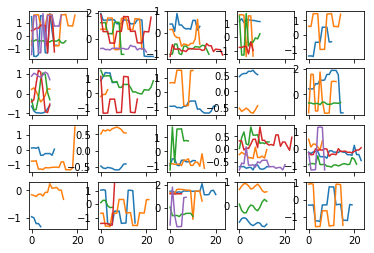

it		avg		std		max		time
1		-0.4551		0.124		-0.118999	11.4001
2		-0.2987		0.11		-0.118999	12.0523
3		-0.2327		0.122		-0.087204	13.6299
4		-0.1778		0.085		-0.061184	13.2587
5		-0.1131		0.072		-0.056704	13.9434


In [8]:
print("standardized train and test data\n")
x_train, x_test = standardize_data(x_train, x_test)
genetic_extractor = GeneticExtractor(**genetic_options)
print_genetic_param(genetic_extractor)
genetic_extractor.fit(x_train, y_train)

In [10]:
distances_train = genetic_extractor.transform(x_train)
distances_test = genetic_extractor.transform(x_test)
lr = LogisticRegression()
lr.fit(distances_train, y_train)

# Print the accuracy score on the test set
accuracy_result = accuracy_score(y_test, lr.predict(distances_test))
print('Accuracy = {}'.format(accuracy_result))

Accuracy = 1.0


In [11]:
lr.predict(distances_test)

array([0, 1])